In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

nltk.download('punkt')

import torch
import torchtext
from torchtext import data
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Please change the following path to your current directory in order to run the code properly
os.chdir("/content/drive/MyDrive/ECE1786/Project")

In [4]:
ls

Bert.ipynb     data_preprocessing.ipynb     Final_Project_v2.ipynb
Bert_v1.ipynb  data_preprocessing_v1.ipynb  model.drawio
data/          Final_Project_v1.ipynb       models/


# Data Preprocessing

## Load the dataset

Dataset 1: Hate Speech and Offensive Language Dataset

In [5]:
# load dataset
dataset1 = pd.read_csv('data/dataset1.csv')
dataset1_bak = dataset1.copy()
dataset1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
# only keep the text and label column
dataset1.drop(dataset1.columns[[0,1,2,3,4]], axis=1, inplace=True)
dataset1

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [7]:
# check the number of rows and columns
dataset1.shape

(24783, 2)

In [8]:
# check if there is any null item
dataset1.isnull().sum()

class    0
tweet    0
dtype: int64

In [9]:
# helper function to convert abbreviated form to original form
def convert_to_original(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

## Data Cleaning

In [10]:
# text data cleaning
def data_processing(text):
  # lower casing
  text = str(text).lower()

  # remove unicode strings
  text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)

  # remove non-ascii characters
  text = re.sub(r'[^\x00-\x7f]', r'', text)

  # remove @user indicaters
  text = re.sub(r'@\w+', r'', text)

  # remove digits
  text = re.sub(r'\d', r'', text)

  # remove '#' symbols inside strings
  text = re.sub(r'#', r'', text)

  # remove rt tag in html
  text = re.sub(r'rt', r'', text)

  # remove “ampersand” reference in html
  text = re.sub(r'amp|&amp', r'', text)

  # remove urls
  text = re.sub(r'http\S+', r'', text)

  # remove multiple white spaces
  text = re.sub(r'[\s]+', r' ', text)

  # remove multiple break-line with single white space.
  text = re.sub(r'[\n]+', r' ', text)

  # split the text (tokenization)
  text = nltk.word_tokenize(text)

  # convert abbreviated form to original form
  text = convert_to_original(' '.join(text)).split()

  # remove short strings with length=1 and length=2
  text = [word for word in text if not len(word) in [1,2]]

  # remove non-alphanumeric characters
  text = [word for word in text if word.isalpha()]

  return ' '.join(text)

In [11]:
dataset1['tweet'] = dataset1['tweet'].apply(data_processing)
dataset1

,class,tweet
0,2,woman you should not complain about cleaning y...
1,1,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,1,dawg you ever fuck bitch and she sta cry you c...
3,1,she look like tranny
4,1,the shit you hear about might true might faker...
...,...,...
24778,1,you muthaf lie right his trash now mine bible ...
24779,2,you have gone and broke the wrong hea baby and...
24780,1,young buck wan eat dat nigguh like aint fuckin...
24781,1,youu got wild bitches tellin you lies


In [12]:
dataset1['tweet'].replace('', np.nan, inplace=True)

In [13]:
dataset1.isnull().sum()

class     0
tweet    10
dtype: int64

In [14]:
dataset1.dropna(subset=['tweet'], inplace=True)

In [15]:
dataset1.isnull().sum()

class    0
tweet    0
dtype: int64

In [16]:
# example before and after data cleaning
print(dataset1_bak['tweet'][0])
print(dataset1['tweet'][0])

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
woman you should not complain about cleaning your house man you should always take the trash out


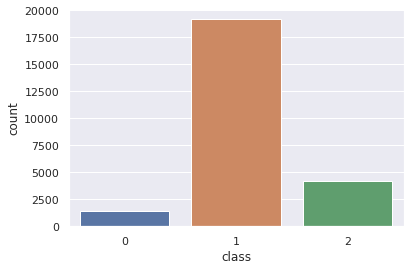

In [17]:
# Before balancing data
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dataset1)

In [18]:
# dataset1
dataset1['class'].value_counts(normalize = True)

1    0.774553
2    0.167723
0    0.057724
Name: class, dtype: float64

In [19]:
len_class_0 = dataset1.groupby(['class'])['class'].count()[0]

In [20]:
sample_size = len_class_0
sampled_dataset1 = dataset1.groupby('class').apply(lambda x: x.sample(sample_size))

In [21]:
sampled_dataset1.reset_index(inplace=True, drop=True)

In [22]:
sampled_dataset1

,class,tweet
0,0,omg ugly faggot your bad mother you should kil...
1,0,joe coez the ultimate faggot that fight proved
2,0,that true idk why your even this convo you dum...
3,0,you little fag least will fuck woman have kids...
4,0,youre fucking ugly bitch wan stab you death an...
...,...,...
4285,2,baby monkey bathtime awwwwe this soooo adorable
4286,2,waits for fanduel hit with the jig
4287,2,how long after the redskins change their nsme ...
4288,2,squad dyke cholas fear nobody they worse than ...


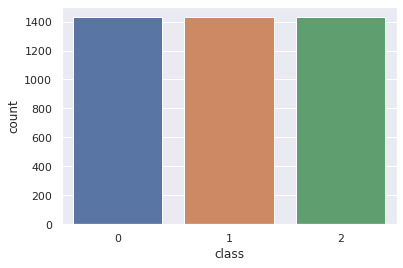

In [23]:
# After balancing data (under-sampling)
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=sampled_dataset1)

In [24]:
sampled_dataset1.to_csv("data/sampled_dataset1.csv")

In [25]:
# create train/validation/test splits
predictor = sampled_dataset1.drop("class", axis = "columns")
X_train_val, X_test, y_train_val, y_test = train_test_split(predictor, sampled_dataset1["class"], test_size=0.2, random_state=20, stratify = sampled_dataset1["class"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=20, stratify = y_train_val)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.to_csv("data/train.tsv", sep="\t")
val.to_csv("data/validation.tsv", sep="\t")
test.to_csv("data/test.tsv", sep="\t")